In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import backtrader as bt

In [2]:
# Binance Vision klines format: https://data.binance.vision/
# Columns: open_time, open, high, low, close, volume, close_time, quote_asset_volume,
#          number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume, ignore
COLUMNS = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]

def load_symbol_data(symbol, interval, data_dir='Data'):
    """
    Load all klines data for a symbol from the Data directory.
    Files are named: {symbol}-{interval}-{YYYY-MM-DD}.csv (e.g. ETHUSDT-15m-2025-12-01.csv)
    """
    pattern = f"{data_dir}/{symbol}-{interval}-*.csv"
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No data found for {symbol} {interval} in {data_dir}")
    dfs = [pd.read_csv(f, names=COLUMNS) for f in files]
    df = pd.concat(dfs, ignore_index=True).sort_values('open_time').reset_index(drop=True)
    return df

df = load_symbol_data('BTCUSDT', '15m')
df['datetime'] = pd.to_datetime(df['open_time'], unit='us')
df['returns'] = df['close'].pct_change()
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,datetime,returns
0,1759276800000000,114048.94,114308.00,114048.93,114156.18,117.94697,1759277699999999,1.346755e+07,26048,75.07159,8.572233e+06,0,2025-10-01 00:00:00,NaN
1,1759277700000000,114156.17,114177.93,113966.67,114021.86,120.20758,1759278599999999,1.371043e+07,30447,47.90822,5.464744e+06,0,2025-10-01 00:15:00,-0.001177
2,1759278600000000,114021.85,114231.26,113969.18,113969.19,99.36776,1759279499999999,1.133745e+07,24505,35.65571,4.069123e+06,0,2025-10-01 00:30:00,-0.000462
3,1759279500000000,113969.19,114255.00,113969.18,114239.53,97.06785,1759280399999999,1.107880e+07,18955,53.58595,6.115732e+06,0,2025-10-01 00:45:00,0.002372
4,1759280400000000,114239.53,114398.97,114142.99,114348.16,149.14275,1759281299999999,1.704863e+07,18602,73.63698,8.416796e+06,0,2025-10-01 01:00:00,0.000951


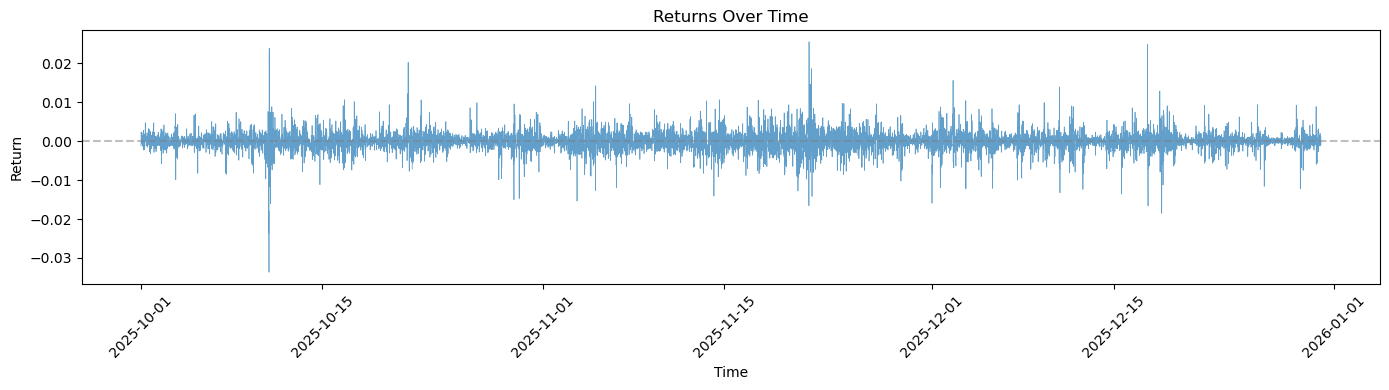

In [3]:
# Returns over time
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['datetime'], df['returns'], alpha=0.7, linewidth=0.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title('Returns Over Time')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

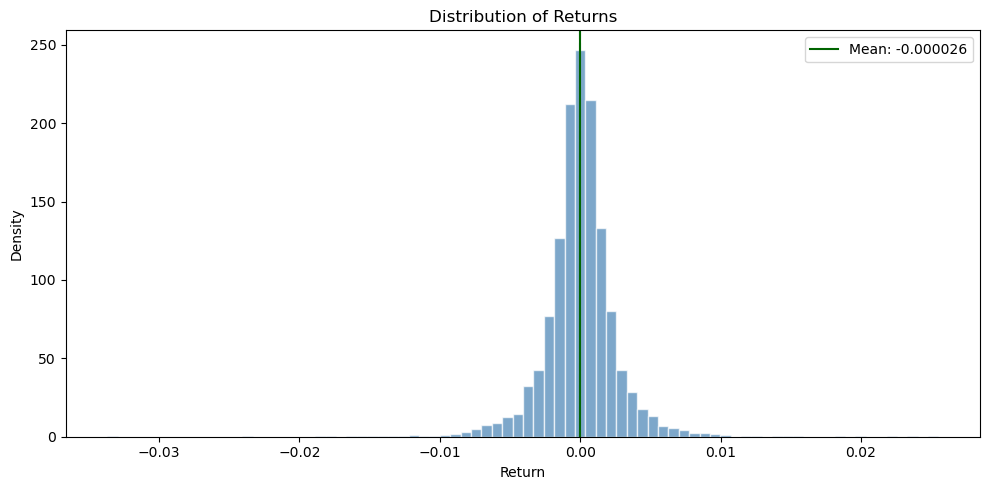

In [4]:
# Distribution of returns
returns = df['returns'].dropna()
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(returns, bins=80, density=True, alpha=0.7, edgecolor='white', color='steelblue')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.8)
ax.axvline(x=returns.mean(), color='darkgreen', linestyle='-', label=f'Mean: {returns.mean():.6f}')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.set_title('Distribution of Returns')
ax.legend()
plt.tight_layout()
plt.show()

## Backtest with Simple MA

Starting Portfolio Value: 10000.0
Ending Portfolio Value: 6355.187029335321


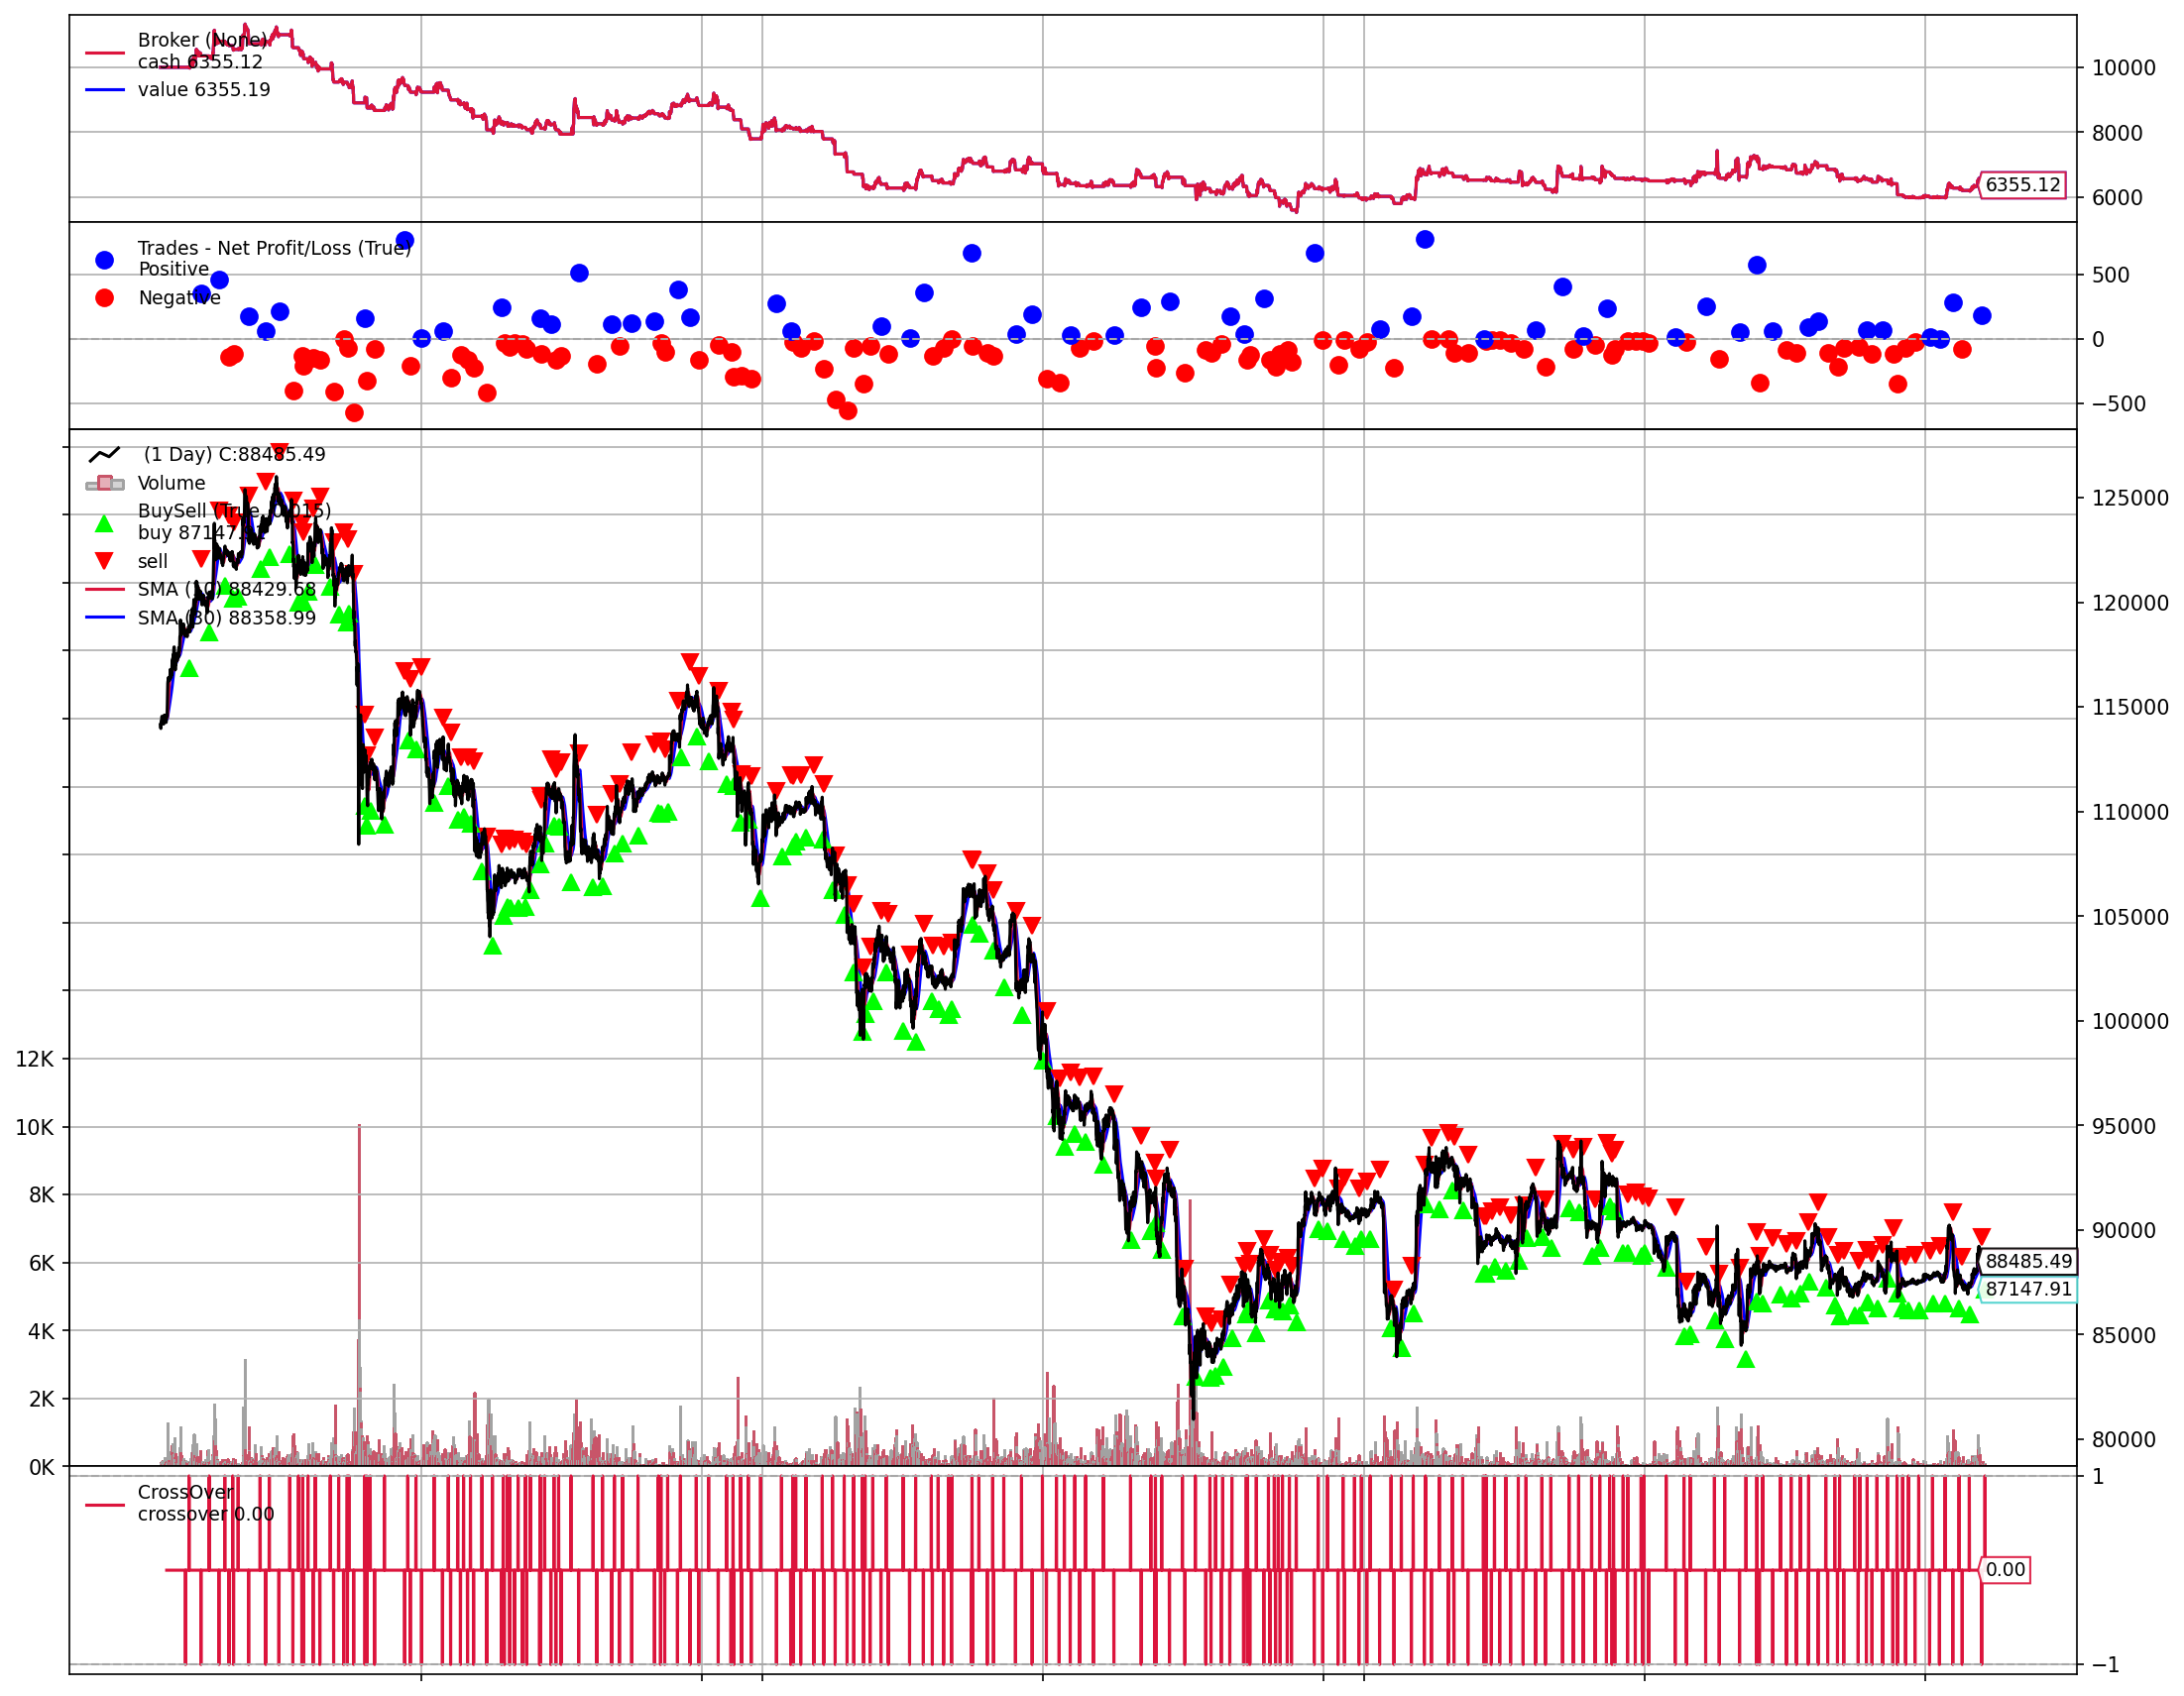

In [5]:
# Backtest configuration - adjust for future tests
BACKTEST_CONFIG = {
    'leverage': 3,
    'initial_cash': 10000.0,
    # Binance Futures commission (USDT-M): https://www.binance.com/en/fee/schedule
    'commission_maker': 0.0002,   # 0.02% - limit orders that add liquidity
    'commission_taker': 0.0005,  # 0.05% - market orders / orders that remove liquidity
    'commission_type': 'taker',  # 'maker' | 'taker' | 'blended' (avg) - use taker for market orders
    'position_pct': 0.95,
    'fast_ma': 10,
    'slow_ma': 30,
}

# Binance Futures commission: maker/taker fee structure
class BinanceFuturesCommInfo(bt.CommInfoBase):
    params = (
        ('stocklike', False),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('percabs', True),
        ('commission_maker', 0.0002),
        ('commission_taker', 0.0005),
        ('commission_type', 'taker'),
    )

    def _getcommission(self, size, price, pseudoexec):
        if self.p.commission_type == 'maker':
            rate = self.p.commission_maker
        elif self.p.commission_type == 'taker':
            rate = self.p.commission_taker
        else:
            rate = (self.p.commission_maker + self.p.commission_taker) / 2
        return abs(size) * price * rate

# Simple MA crossover strategy: buy when fast MA crosses above slow MA, sell when below
class MAStrategy(bt.Strategy):
    params = (('fast', 10), ('slow', 30))

    def __init__(self):
        self.fast_ma = bt.indicators.SMA(self.data.close, period=self.params.fast)
        self.slow_ma = bt.indicators.SMA(self.data.close, period=self.params.slow)
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        else:
            if self.crossover < 0:
                self.close()


# Oversold Bounce: high win rate mean reversion - buy extreme dips in uptrend, quick take profit
class OversoldBounceStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),
        ('rsi_oversold', 28),
        ('rsi_exit', 55),
        ('trend_ma', 50),
        ('takeprofit_pct', 0.015),
        ('stoploss_pct', 0.006),
    )

    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.bb = bt.indicators.BollingerBands(self.data.close, period=20, devfactor=2)
        self.trend_sma = bt.indicators.SMA(self.data.close, period=self.params.trend_ma)
        self.entry_price = None

    def next(self):
        price = self.data.close[0]
        if not self.position:
            # Uptrend filter + extreme oversold
            in_uptrend = price > self.trend_sma[0]
            oversold = self.rsi[0] < self.params.rsi_oversold
            below_lower_bb = price <= self.bb.lines.bot[0]
            if in_uptrend and oversold and below_lower_bb:
                self.buy()
                self.entry_price = price
        else:
            if self.entry_price is None:
                self.entry_price = self.position.price
            pnl_pct = (price - self.entry_price) / self.entry_price
            # Take profit
            if pnl_pct >= self.params.takeprofit_pct:
                self.close()
                self.entry_price = None
            # Stop loss
            elif pnl_pct <= -self.params.stoploss_pct:
                self.close()
                self.entry_price = None
            # RSI recovered
            elif self.rsi[0] > self.params.rsi_exit:
                self.close()
                self.entry_price = None


# Multi-timeframe: signals on 15m, TP/SL on 1m (requires 1m data - run BinanceCollector with interval="1m")
# self.datas[0]=1m, self.datas[1]=15m (resampled)
class OversoldBounceMTFStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14), ('rsi_oversold', 28), ('rsi_exit', 55),
        ('trend_ma', 50), ('takeprofit_pct', 0.015), ('stoploss_pct', 0.006),
    )

    def __init__(self):
        # Indicators on 15m (datas[1]) for signal generation
        self.rsi = bt.indicators.RSI(self.datas[1].close, period=self.params.rsi_period)
        self.bb = bt.indicators.BollingerBands(self.datas[1].close, period=20, devfactor=2)
        self.trend_sma = bt.indicators.SMA(self.datas[1].close, period=self.params.trend_ma)
        self.entry_price = None

    def next(self):
        # Price from 1m (datas[0]) for granular TP/SL
        price_1m = self.datas[0].close[0]
        price_15m = self.datas[1].close[0]
        if not self.position:
            in_uptrend = price_15m > self.trend_sma[0]
            oversold = self.rsi[0] < self.params.rsi_oversold
            below_lower_bb = price_15m <= self.bb.lines.bot[0]
            if in_uptrend and oversold and below_lower_bb:
                self.buy(data=self.datas[0])
                self.entry_price = price_1m
        else:
            if self.entry_price is None:
                self.entry_price = self.position.price
            pnl_pct = (price_1m - self.entry_price) / self.entry_price
            if pnl_pct >= self.params.takeprofit_pct:
                self.close(data=self.datas[0])
                self.entry_price = None
            elif pnl_pct <= -self.params.stoploss_pct:
                self.close(data=self.datas[0])
                self.entry_price = None
            elif self.rsi[0] > self.params.rsi_exit:
                self.close(data=self.datas[0])
                self.entry_price = None

# Prepare data for backtrader: datetime index, OHLCV columns
bt_data = df[['open', 'high', 'low', 'close', 'volume']].copy()
bt_data.index = pd.to_datetime(df['datetime'])
bt_data.index.name = 'datetime'

# Run backtest
cfg = BACKTEST_CONFIG
cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=bt_data))
cerebro.addstrategy(MAStrategy, fast=cfg['fast_ma'], slow=cfg['slow_ma'])
cerebro.broker.setcash(cfg['initial_cash'])
# Binance Futures commission with maker/taker rates + margin for leverage
comminfo = BinanceFuturesCommInfo(
    commission_maker=cfg['commission_maker'],
    commission_taker=cfg['commission_taker'],
    commission_type=cfg['commission_type'],
    margin=1 / cfg['leverage'],
)
cerebro.broker.addcommissioninfo(comminfo)
# Position size: pct of margin (cash * leverage * pct)
cerebro.addsizer(bt.sizers.PercentSizer, percents=cfg['position_pct'] * cfg['leverage'] * 100)

print('Starting Portfolio Value:', cerebro.broker.getvalue())
cerebro.run()
print('Ending Portfolio Value:', cerebro.broker.getvalue())

import io
from IPython.display import Image, display
plt.rcParams['figure.figsize'] = [15, 12]
figs = cerebro.plot(iplot=False)
for figlist in figs:
    for fig in figlist:
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        display(Image(data=buf.getvalue()))
        plt.close(fig)

## Oversold Bounce Strategy (High Win Rate)

Mean reversion: buy extreme oversold dips in uptrend, take quick profit. Target: many small wins, few small losses.

=== Oversold Bounce Strategy ===
Total trades: 0 | Won: 0 | Lost: 0
Win rate: 0.0%
Starting: $10,000.00 | Ending: $10,000.00
Total return: 0.00%


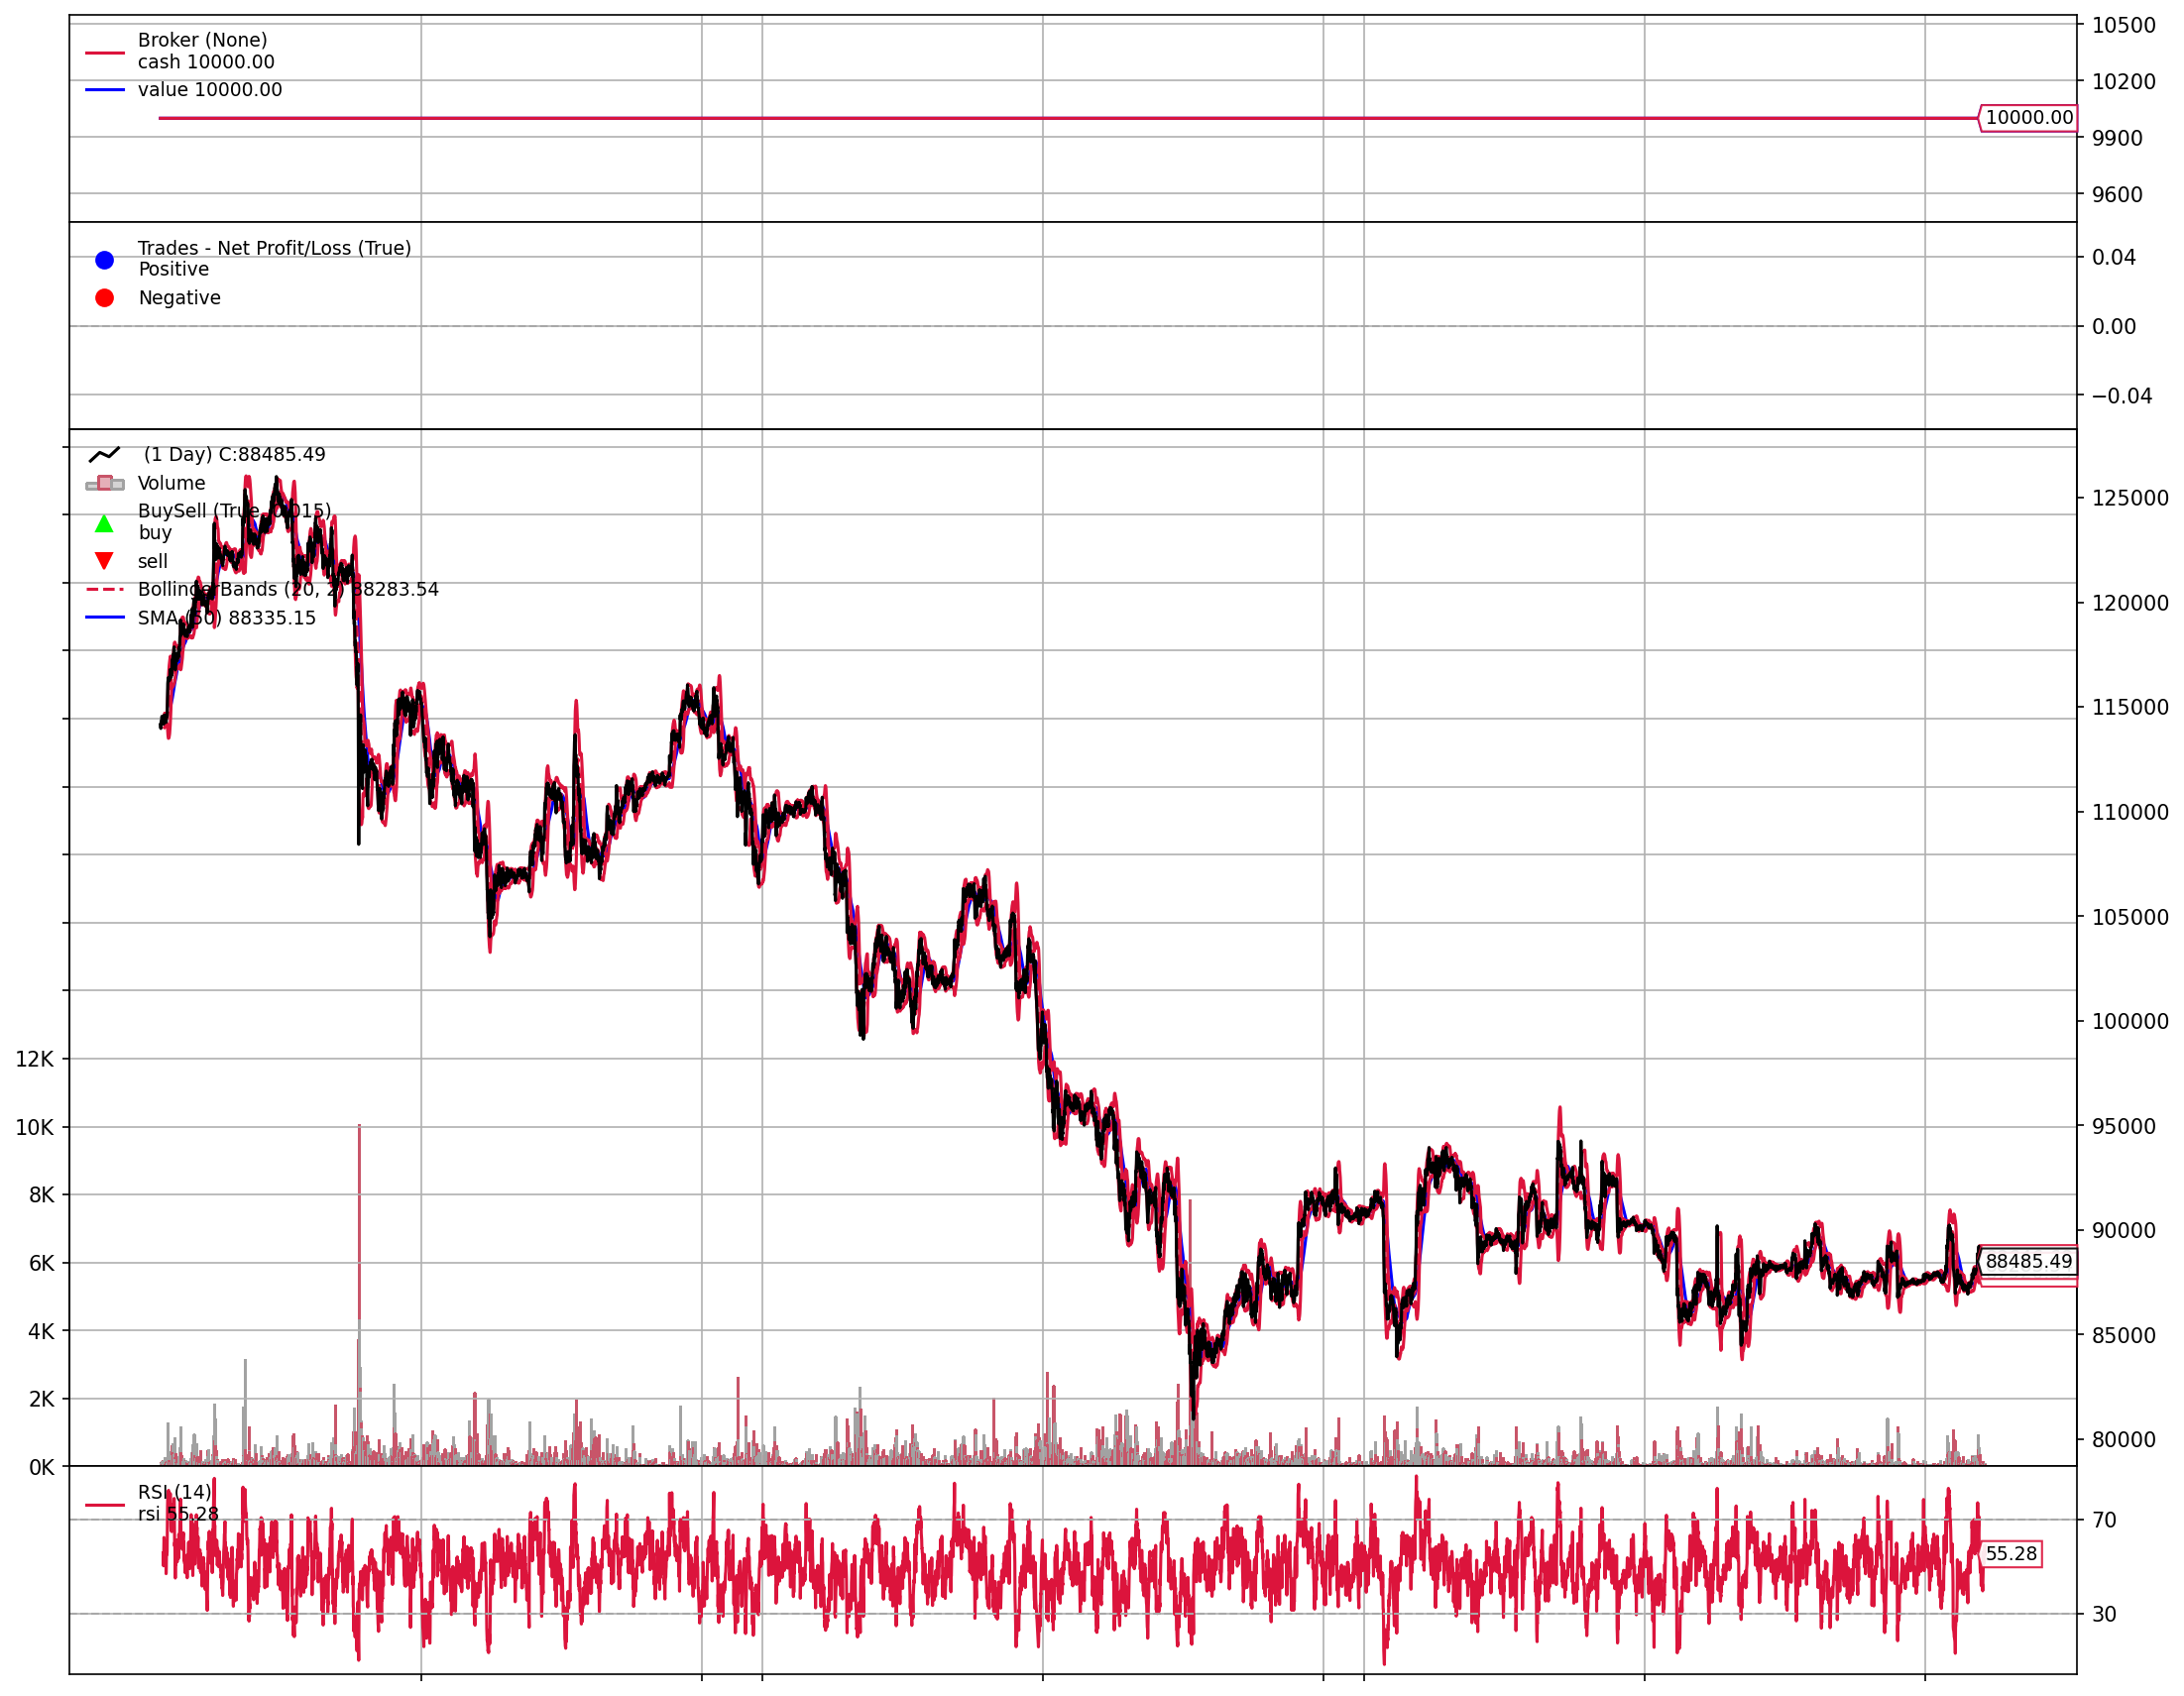

In [6]:
# Run Oversold Bounce strategy (high win rate)
cfg = BACKTEST_CONFIG
cerebro2 = bt.Cerebro()
cerebro2.adddata(bt.feeds.PandasData(dataname=bt_data))
cerebro2.addstrategy(OversoldBounceStrategy)
cerebro2.broker.setcash(cfg['initial_cash'])
comminfo2 = BinanceFuturesCommInfo(
    commission_maker=cfg['commission_maker'],
    commission_taker=cfg['commission_taker'],
    commission_type=cfg['commission_type'],
    margin=1 / cfg['leverage'],
)
cerebro2.broker.addcommissioninfo(comminfo2)
cerebro2.addsizer(bt.sizers.PercentSizer, percents=cfg['position_pct'] * cfg['leverage'] * 100)
cerebro2.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

results = cerebro2.run()
strat = results[0]
ta = strat.analyzers.trades.get_analysis()

total = ta.get('total', {}).get('total', 0) or 0
won = ta.get('won', {}).get('total', 0) or 0
lost = ta.get('lost', {}).get('total', 0) or 0
win_rate = (won / total * 100) if total > 0 else 0
start_val = cerebro2.broker.startingcash
end_val = cerebro2.broker.getvalue()
total_return = (end_val - start_val) / start_val * 100

print('=== Oversold Bounce Strategy ===')
print(f'Total trades: {total} | Won: {won} | Lost: {lost}')
print(f'Win rate: {win_rate:.1f}%')
print(f'Starting: ${start_val:,.2f} | Ending: ${end_val:,.2f}')
print(f'Total return: {total_return:.2f}%')

import io
from IPython.display import Image, display
plt.rcParams['figure.figsize'] = [15, 12]
figs = cerebro2.plot(iplot=False)
for figlist in figs:
    for fig in figlist:
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        display(Image(data=buf.getvalue()))
        plt.close(fig)

## Multi-Timeframe: 15m Signals + 1m TP/SL

Signals (RSI, BB, trend) on 15m; TP/SL checked on 1m for finer exits. **Requires 1m data** – run BinanceCollector with `interval="1m"` first.

In [ ]:
# Multi-timeframe backtest: 1m base -> resample to 15m for signals, 1m for TP/SL
try:
    df_1m = load_symbol_data('ETHUSDT', '1m')  # Requires 1m data from BinanceCollector
    df_1m['datetime'] = pd.to_datetime(df_1m['open_time'], unit='us')
    bt_data_1m = df_1m[['open', 'high', 'low', 'close', 'volume']].copy()
    bt_data_1m.index = pd.to_datetime(df_1m['datetime'])
    bt_data_1m.index.name = 'datetime'

    cfg = BACKTEST_CONFIG
    cerebro_mtf = bt.Cerebro()
    # Add 1m first (smallest timeframe)
    data_1m = bt.feeds.PandasData(dataname=bt_data_1m)
    cerebro_mtf.adddata(data_1m)
    # Resample 1m -> 15m for signal indicators
    cerebro_mtf.resampledata(data_1m, timeframe=bt.TimeFrame.Minutes, compression=15)
    cerebro_mtf.addstrategy(OversoldBounceMTFStrategy)
    cerebro_mtf.broker.setcash(cfg['initial_cash'])
    comminfo_mtf = BinanceFuturesCommInfo(
        commission_maker=cfg['commission_maker'],
        commission_taker=cfg['commission_taker'],
        commission_type=cfg['commission_type'],
        margin=1 / cfg['leverage'],
    )
    cerebro_mtf.broker.addcommissioninfo(comminfo_mtf)
    cerebro_mtf.addsizer(bt.sizers.PercentSizer, percents=cfg['position_pct'] * cfg['leverage'] * 100)
    cerebro_mtf.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

    results = cerebro_mtf.run()
    ta = results[0].analyzers.trades.get_analysis()
    total = ta.get('total', {}).get('total', 0) or 0
    won = ta.get('won', {}).get('total', 0) or 0
    win_rate = (won / total * 100) if total > 0 else 0
    start_val, end_val = cerebro_mtf.broker.startingcash, cerebro_mtf.broker.getvalue()

    print('=== MTF: 15m Signals + 1m TP/SL ===')
    print(f'Trades: {total} | Won: {won} | Win rate: {win_rate:.1f}%')
    print(f'Return: {(end_val-start_val)/start_val*100:.2f}%')

    import io
    from IPython.display import Image, display
    plt.rcParams['figure.figsize'] = [15, 12]
    figs = cerebro_mtf.plot(iplot=False)
    for figlist in figs:
        for fig in figlist:
            buf = io.BytesIO()
            fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
            buf.seek(0)
            display(Image(data=buf.getvalue()))
            plt.close(fig)
except FileNotFoundError as e:
    print("1m data not found. Run BinanceCollector with interval='1m' first:")
    print("  obj = BinanceCollector('ETHUSDT', '2025-10-01', '2025-12-31', '1m')")
    print("  obj.start_collect()")

In [7]:
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 1500x1200 with 5 Axes>]]